In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Percorsi
INPUT_PATH = "../data/processed/billionaires_clean_numeric.csv"
OUTPUT_DIR = "../data/splitted"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Caricamento dati
df = pd.read_csv(INPUT_PATH)

# Carica il dataset (modifica il path con il tuo)
# 1. Numero di righe totali
num_righe = df.shape[0]
print(f"Numero totale di righe: {num_righe}")

# 2. Calcolo outlier colonna per colonna usando IQR
def conta_outlier_serie(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    soglia_bassa = q1 - 1.5 * iqr
    soglia_alta = q3 + 1.5 * iqr
    return ((serie < soglia_bassa) | (serie > soglia_alta)).sum()

# Applica solo alle colonne numeriche
outlier_per_colonna = df.select_dtypes(include='number').apply(conta_outlier_serie)
tot_outlier = outlier_per_colonna.sum()

# 3. Stampa
print("\nNumero di outlier per colonna:")
print(outlier_per_colonna)
print(f"\nNumero totale di outlier nel dataset (su singole celle): {tot_outlier}")


Numero totale di righe: 2602

Numero di outlier per colonna:
rank                                            0
finalWorth                                    237
personName                                      0
age                                             6
city                                            0
source                                          0
organization                                    0
title                                           0
birthYear                                       7
birthMonth                                      0
birthDay                                        0
cpi_country                                   469
cpi_change_country                              4
gdp_country                                     0
gross_tertiary_education_enrollment             0
gross_primary_education_enrollment_country    343
life_expectancy_country                       182
tax_revenue_country_country                   409
total_tax_rate_country                 


Numero di outlier per colonna:
latitude_country                              847
cpi_country                                   469
tax_revenue_country_country                   409
gross_primary_education_enrollment_country    343
finalWorth                                    237
life_expectancy_country                       182
birthYear                                       7
age                                             6
cpi_change_country                              4
total_tax_rate_country                          4
dtype: int64

Numero totale di outlier nel dataset (celle anomale): 2508


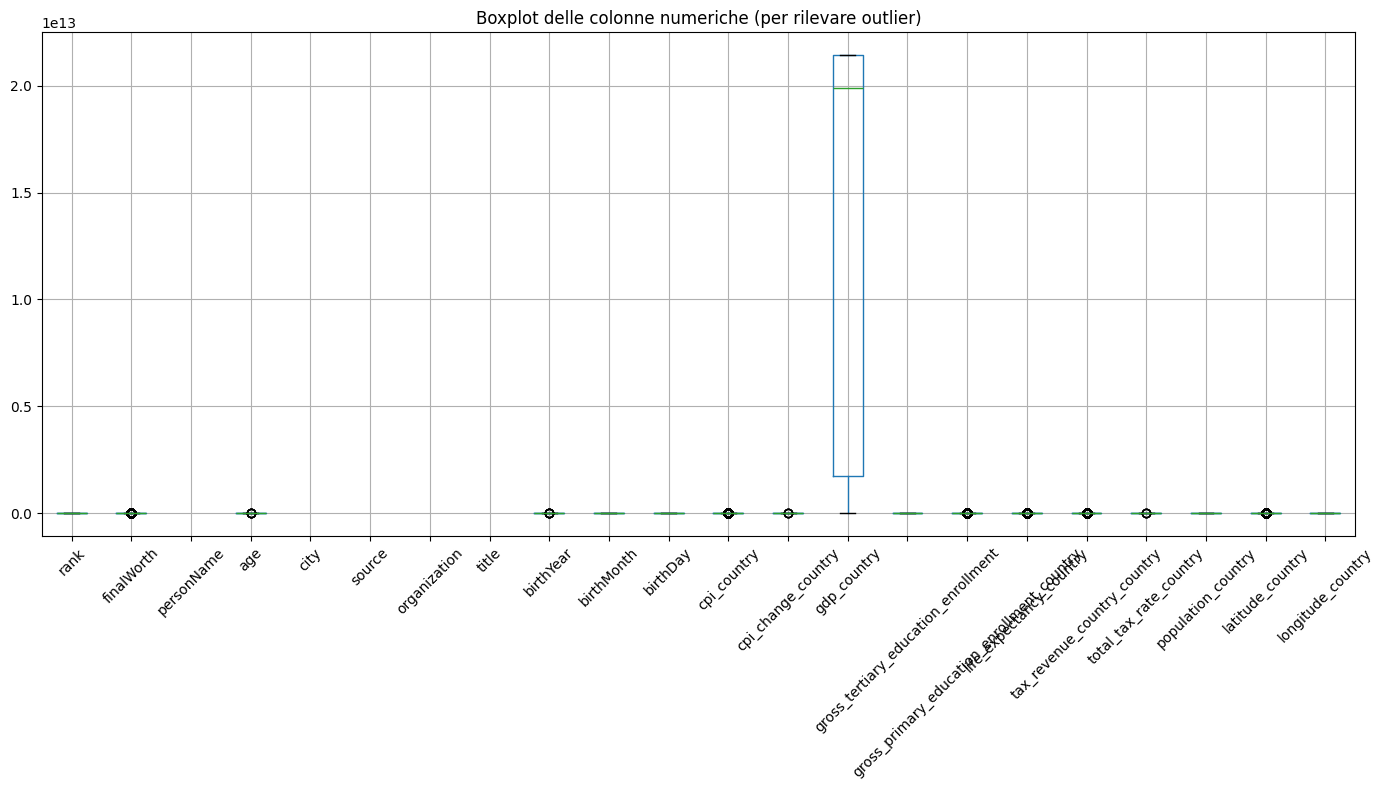

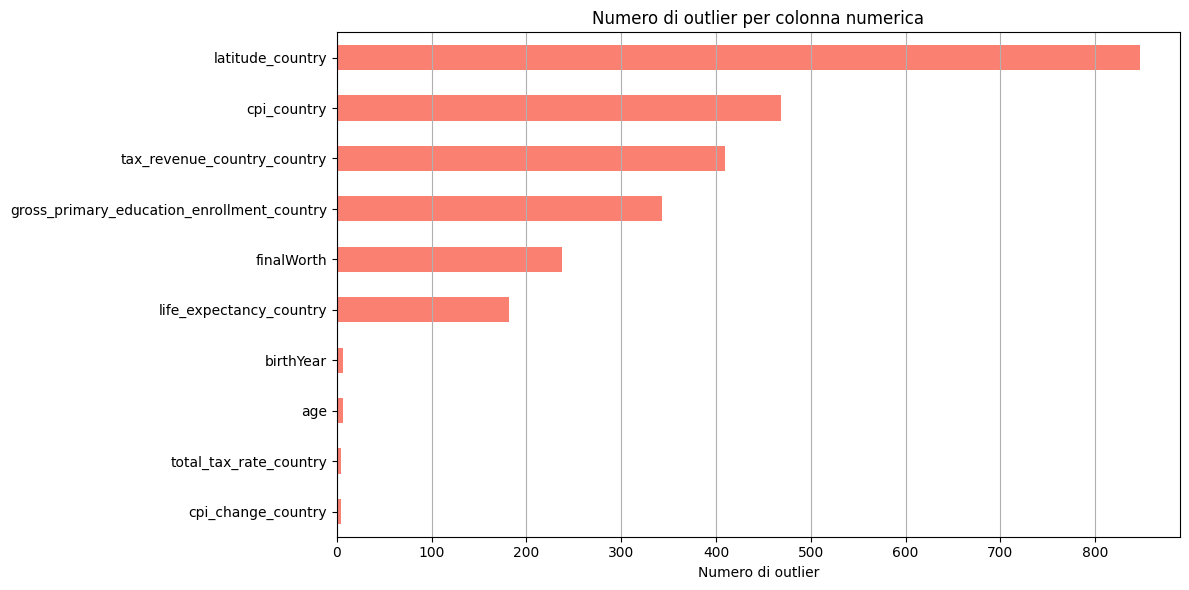

In [11]:
import matplotlib.pyplot as plt
risultati = "../results/outlier"

colonne_numeriche = df.select_dtypes(include='number')
outlier_per_colonna = colonne_numeriche.apply(conta_outlier_serie)
tot_outlier = outlier_per_colonna.sum()

# === 4. Stampa info outlier ===
print("\nNumero di outlier per colonna:")
print(outlier_per_colonna[outlier_per_colonna > 0].sort_values(ascending=False))
print(f"\nNumero totale di outlier nel dataset (celle anomale): {tot_outlier}")

# === 5. Boxplot ===
plt.figure(figsize=(14, 8))
colonne_numeriche.boxplot(rot=90)
plt.title('Boxplot delle colonne numeriche (per rilevare outlier)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{risultati}/boxplot_colonne_numeriche.png")
plt.show()

plt.figure(figsize=(12, 6))
outlier_per_colonna[outlier_per_colonna > 0].sort_values(ascending=True).plot(kind='barh', color='salmon')
plt.xlabel("Numero di outlier")
plt.title("Numero di outlier per colonna numerica")
plt.grid(axis='x')
plt.tight_layout()
plt.savefig(f"{risultati}/barplot_numero_outlier_per_colonna.png")
plt.show()


In [12]:
# l'attributo gdp è anomalo rispetto agli altri
print(df["gdp_country"].describe())


count    2.476000e+03
mean     1.158287e+13
std      9.575588e+12
min      3.154058e+09
25%      1.736426e+12
50%      1.991000e+13
75%      2.142770e+13
max      2.142770e+13
Name: gdp_country, dtype: float64


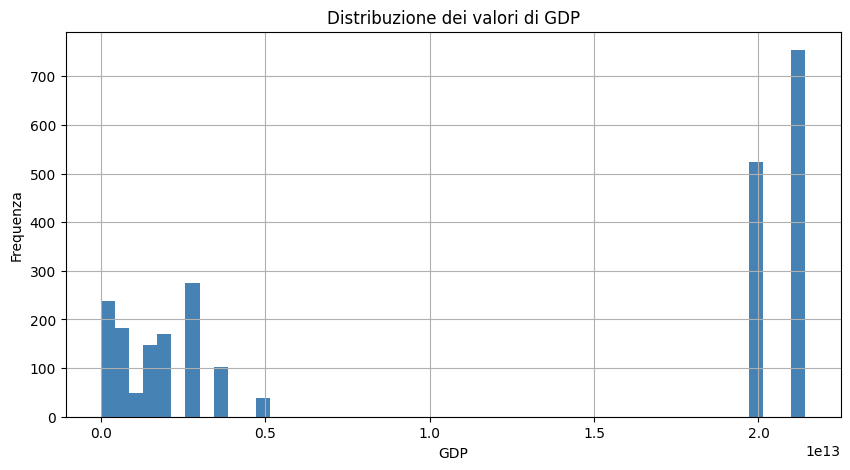

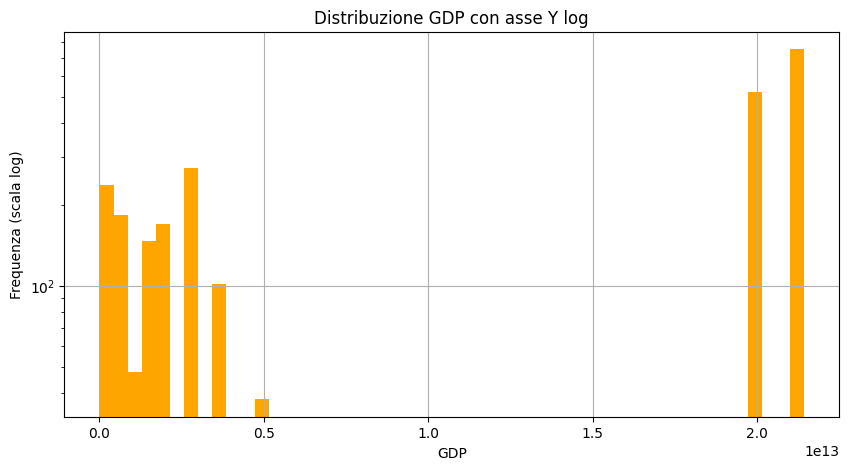

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df["gdp_country"], bins=50, color='steelblue')
plt.title("Distribuzione dei valori di GDP")
plt.xlabel("GDP")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.hist(df["gdp_country"], bins=50, color='orange', log=True)
plt.title("Distribuzione GDP con asse Y log")
plt.xlabel("GDP")
plt.ylabel("Frequenza (scala log)")
plt.grid(True)
plt.show()


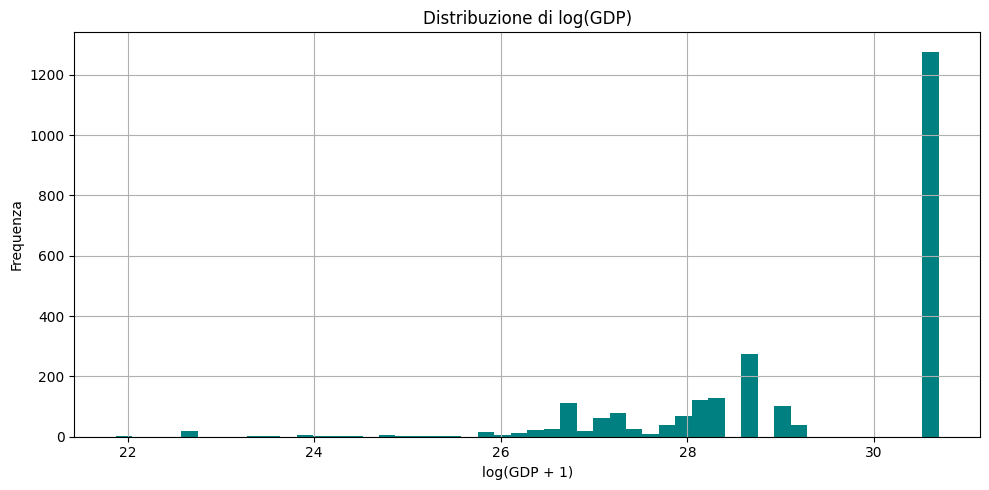

In [14]:
import numpy as np

df["log_gdp_country"] = np.log1p(df["gdp_country"])

# Istogramma dei log-GDP
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df["log_gdp_country"], bins=50, color='teal')
plt.title("Distribuzione di log(GDP)")
plt.xlabel("log(GDP + 1)")
plt.ylabel("Frequenza")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np



df["log_finalWorth"] = np.log1p(df["finalWorth"])
df["log_gdp_country"] = np.log1p(df["gdp_country"])

# Selezione feature numeriche e categoriche
numerical_cols = ['log_finalWorth', 'age', 'log_gdp_country', 'cpi_country',
                  'life_expectancy_country', 'gross_tertiary_education_enrollment',
                  'total_tax_rate_country', 'population_country']

categorical_cols = ['country', 'category', 'industries', 'source']

# Target
target = 'selfMade'

# Encoding variabili categoriche
categorical_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# Costruzione del dataset finale
X = pd.concat([df[numerical_cols], categorical_encoded], axis=1)
X = X.fillna(X.median())
y = df[target]

# Rimozione dei record con target mancante 
mask = y.notna()
X = X[mask]
y = y[mask]

In [16]:
# Split train/test con stratificazione
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Salvataggio dei dataset
X_train.to_csv(os.path.join(OUTPUT_DIR, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(OUTPUT_DIR, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(OUTPUT_DIR, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(OUTPUT_DIR, "y_test.csv"), index=False)

print("\n✅ Dataset (completo) diviso e salvato in 'data/splitted/'")



✅ Dataset (completo) diviso e salvato in 'data/splitted/'
